In [1]:
import jupyros
import rospy
from std_msgs.msg import Int32MultiArray as i32arr
from geometry_msgs.msg import Pose, PoseStamped, Point
from nav_msgs.msg import Odometry
from assignment_2_2023.msg import Pos_vel
from assignment_2_2023.msg import PlanningAction, PlanningGoal, PlanningActionGoal
import assignment_2_2023 as assig
import ipywidgets as widg
from ipywidgets import Output
import actionlib
import actionlib_msgs
import threading
from IPython.display import display, clear_output
import matplotlib
import matplotlib.pyplot as pyplt
from matplotlib.animation import FuncAnimation 
import numpy as np
#from actionlib_msgs.msg import GoalStatusArray, GoalStatus
    

rospy.init_node ('reach_position')
print ('all working')


all working


In [2]:
client = actionlib.SimpleActionClient ('/reaching_goal', PlanningAction)


goal = PlanningGoal ()
des_x = 0
des_y = 0
goal_set = 0
goal_list = []
goal_canc_list = []
goal_out = Output ()

targ_num_pub = rospy.Publisher ('/target_amount', i32arr, queue_size = 1)
targ_nums = i32arr ()
targ_nums.data.append (0)
targ_nums.data.append(0)


def goal_finished (term_state, res):
    global goal_set
    goal_set = 0

def setgoal (b):
    global des_x, des_y, goal, goal_set, goal_list, goal_out, client, targ_nums, targ_num_pub
    #state = client.get_state ()
    #print (client.gh)
    goal_active = True
    if not client.gh is None:
        goal_active = client.get_result ()
    if goal_active:
        #targ_Stamp = PoseStamped        
        target = PoseStamped ()
        #targ_pos = Point
        #targ_pos.x = des_x
        #targ_pos.y = des_y
        #target.position = targ_pos
        target.pose.position.x = des_x
        target.pose.position.y = des_y
        #targ_Stamp.pose = target
        #goal.target_pose = targ_Stamp
        client.stop_tracking_goal ()
        goal = PlanningGoal ()
        goal.target_pose = target
        client.send_goal (goal, done_cb = goal_finished)
        goal_list.append (goal)
        targ_nums.data[0] += 1
        targ_num_pub.publish (targ_nums)
        with goal_out: 
            clear_output ()
            print ('goal sent successfully')
    else:
        with goal_out:
            clear_output ()
            print ('goal already active, cancel the previous one first')
        
    

start = widg.Button (description ='set the target position, then press this button to start reaching the goal', 
                     layout = widg.Layout(width = '50%', height = '80px'))
x_in = widg.IntText ()
y_in = widg.IntText ()
slid_box = widg.Box([x_in, y_in])

def x_change (change):
    global des_x
    des_x = change ['new'] + 0.0
    
def y_change (change):
    global des_y
    des_y = change['new'] + 0.0
    

x_in.observe (x_change, names = 'value')
y_in.observe (y_change, names = 'value')
client.wait_for_server()

start_box = widg.VBox ([slid_box, start])
def goal_cancel (b):
    global goal, goal_set, goal_list, goal_canc_list, goal_out, client, targ_nums, targ_num_pub
    goal_active = False
    if not client.gh is None:
        goal_active = not client.get_result ()
    if goal_active:
        #goal_list. pop()
        goal_canc_list.append (goal)
        client.cancel_goal()
        client.gh = None
        targ_nums.data[1] += 1
        targ_num_pub.publish (targ_nums)
        with goal_out: 
            clear_output ()
            print ('goal cancelled')
        
        
end = widg.Button (description = 'press this button oo cancel the goal sent', 
                  layout = widg.Layout (width = '50%', height = '80px'))
button_box = widg.VBox ([start_box, end])
"""
def start_stop ():
    
    end.on_click (goal_cancel)
    start.on_click(setgoal)
    display (widg.HBox ([button_box, goal_out]))
    rospy.spin ()

t_start_stop = threading.Thread (target = start_stop, args = ())  
t_start_stop.start ()
"""

end.on_click (goal_cancel)
start.on_click(setgoal)


pub_msg = Pos_vel ()
des_rate = 20
rate = rospy.Rate (des_rate)
def odom_cb (od_msg):
    global pub_msg
    pub_msg.x = od_msg.pose.pose.position.x
    pub_msg.y = od_msg.pose.pose.position.y
    pub_msg.vel_x = od_msg.twist.twist.linear.x
    pub_msg.vel_y = od_msg.twist.twist.linear.y
    #print ('message uploaded')
pub = rospy.Publisher ('/act_pos_vel', Pos_vel, queue_size = 1)
sub = rospy.Subscriber ('/odom', Odometry, odom_cb)
def message_publish ():
    global pub_msg, rate
    while not rospy.is_shutdown():
        pub.publish (pub_msg)
        #end.on_click (goal_cancel)
        #start.on_click(setgoal)
        rate.sleep()
        
t_pub = threading.Thread (target = message_publish, args = ())
t_pub.start ()

"""
#desc = widg.Textarea (value = 'current robot position:', description = 'string:')
out = widg.Output ()
display (out)
"""
out = widg.Output ()
pos_button = widg.Button (description = 'press this button to get the current position of the robot', 
                  layout = widg.Layout (width = '50%', height = '80px'))

def disp_pos (b):
    global pub_msg, out
    x = pub_msg.x
    y = pub_msg.y
    
    with out:
        clear_output ()
        print ('\ncurrent robot position:\n', x, y)

pos_button.on_click (disp_pos)


targ_out = Output ()
canc_targ_out = Output ()
def disp_goal (b):
    global targ_out, goal_list
    with targ_out:
        clear_output ()
        #print (goal_list)
        for targ in goal_list:
            print (targ.target_pose.pose.position.x, targ.target_pose.pose.position.y)
            print ('---------------------------------------------------------')
        
        
def disp_canc_goal (b):
    global canc_targ_out, goal_canc_list
    with canc_targ_out:
        clear_output ()
        for targ in goal_canc_list:
            print (targ.target_pose.pose.position.x, targ.target_pose.pose.position.y)
            print ('---------------------------------------------------------')
    
goal_but = widg.Button (description = 'press this button to get the list of sent targets', 
                  layout = widg.Layout (width = '100%', height = '80px'))
canc_but = widg.Button (description = 'press this button to get the list of cancelled targets', 
                  layout = widg.Layout (width = '100%', height = '80px'))

goal_but.on_click (disp_goal)

canc_but.on_click (disp_canc_goal)

goal_box = widg.VBox ([goal_but, targ_out])
canc_box = widg.VBox ([canc_but, canc_targ_out])


%matplotlib notebook
#bar_out = Output ()
x_el = ('goals sent', 'goals cancelled')
bar_width = 0.8
#x_ind = (bar_width, 2 * bar_width)
x_ind = np.arange (1, 3) * bar_width
#y_el = (len (goal_list), len (goal_canc_list))

class Visualiser:
    def __init__(self):
        self.fig, self.ax = pyplt.subplots(2, 1)
        self.fig.set_figheight (10)
        self.fig.set_figwidth (8)
        self.ln1, self.ln2, = self.ax [0].plot([], [], 'ro', [], [], 'bo')
        #self.bar = self.ax [1].bar(x_ind, [0, 0], bar_width, label = x_el, align = 'center')
        #self.bar = self.ax [1].bar(x_el, [0, 0], bar_width, align = 'center')
        self.bar = self.ax [1].barh(x_el, [0, 0], bar_width, align = 'center', color = ('blue', 'red'))
        #self.bar.set_xlabel (x_el)
        self.x_data, self.y_data = [] , []
        self.target_x, self. target_y = [], []
        self.canc_x, self.canc_y = [], []
        self.ax [0].set_xlim(-10, 10)
        self.ax [0].set_ylim(-10, 10)
        self.ax [0].set_xlabel ('x coordinate of robot (red) \nand last target sent (blue)')
        self.ax [0].set_ylabel ('y coordinate of robot (red) \nand last target sent (blue)')
        self.ax [0].invert_xaxis ()
        self.ax [0].invert_yaxis ()
        #print ('subplots initialized')
        #self.ax [1].set_xlim (0, 3 * bar_width)
        self.ax [1].set_xlim (0, 10)
        self.ax [1].set_ylabel ('number of targets sent or cancelled')
        self.ax [1].grid (True, axis = 'x')
        #pyplt.xticks (x_ind + bar_width / 2, x_el)
        #self.ax [1].bar_label (x_el)
        #self.ax [1].bar_label (self.bar, label_type = 'center')
        #self.ax [1].ylabel ('amount of targets')
        #self


    def plot_init(self):
        return (self.ln1, self.ln2, self.bar)#_init ())
        
        
    def odom_callback(self, msg):
        #self.y_data.append(msg.y)
        #self.x_data.append(msg.x)
        self.y_data.append(msg.pose.pose.position.y)
        self.x_data.append(msg.pose.pose.position.x)
        

    def update_plot(self, frame):
        self.ln1.set_data(self.x_data, self.y_data)
        if len (self.target_x) != 0:
            self.ln2.set_data ([self.target_x [-1]], [self.target_y [-1]])
        #self.ln.plot(self.x_data, self.y_data, 'ro', self.targte_x [-1], self.target_y [-1], 'bo')
        #self.ax[0].draw ()
        #print ('updationg plot')
        #return (self.ln1, self.ln2)
        return (self.ln1, self.ln2, self.update_bar ())

    def new_goal (self, msg):
        self.target_x.append (msg.goal.target_pose.pose.position.x)
        self.target_y.append (msg.goal.target_pose.pose.position.y)

    def deleted_goal (self, msg):
        self.canc_x.append (self.target_x [-1])
        self.canc_y.append (self.target_y [-1])

    def update_bar (self):
        h_el = (len (self.target_x), len (self.canc_x))
        self.ax [1].cla ()
        #self.bar = self.ax [1].bar (x_ind, h_el, color = ('blue', 'red'))
        #self.ax [1].set_ylim (0, max (h_el) + 2)
        #self.ax [1].set_xlim (0, 3 * bar_width)
        #for b,h in zip (self.bar.patches, h_el):
            #b.set_height (h)
        self.bar = self.ax [1].barh (x_ind, h_el, color = ('blue', 'red'))
        self.ax [1].set_xlim (0, max (h_el) + 2)
        self.ax [1].invert_yaxis ()
        #self.ax [1].xlabel ()
        self.ax [1].bar_label (self.bar, padding = 10)
        self.ax [1].set_yticks (x_ind, x_el, rotation = 90, verticalalignment = 'center')
        self.ax [1].grid (True, axis = 'x')
        return self.bar

In [3]:
display (widg.VBox ([button_box, goal_out]))

In [4]:
display (widg.VBox ([pos_button, out]))

In [5]:
display (widg.HBox ([goal_box, canc_box]))

<IPython.core.display.Javascript object>


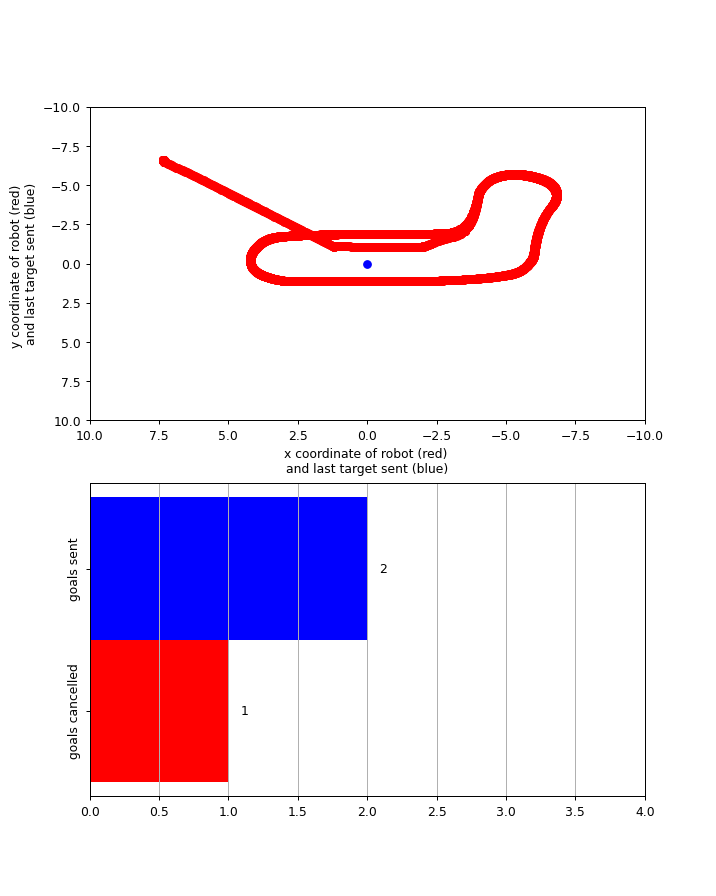

In [6]:
rob_vis = Visualiser ()
plot_bar_ani = FuncAnimation (rob_vis.fig, rob_vis.update_plot, init_func=rob_vis.plot_init, cache_frame_data = False, blit = True)
rob_pos_sub = rospy.Subscriber ('/odom', Odometry, rob_vis.odom_callback)
goal_sub = rospy.Subscriber ('/reaching_goal/goal', PlanningActionGoal, rob_vis.new_goal)
goal_canc_sub = rospy.Subscriber ('/reaching_goal/cancel', actionlib_msgs.msg.GoalID, rob_vis.deleted_goal)
pyplt.show(block = True)
